## Single Pipeline hyperparameter optimization
Before adding hyperparameter search option to the Experiment Graph, we perform a simple analysis where we select the one pipeline and for every execution we add the hyperparameters and the final accuracy to the Trial object of the hypernet. Afterwards, we perform a search using a predefined budget to find the best set of parameters.
We compare the result, with the vanilla version, where the Trial object is empty and report the quality and time to achieve the certain level of quality.

In [1]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
%matplotlib inline


config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [2]:
flow = flows.get_flow(flow_id=7707)
task = tasks.get_task(task_id=31)
pipeline = flows.flow_to_sklearn(flow)

In [3]:
import pickle
def getTopRuns(numberOfRuns, pipeline, task):
    openMlEvaluations = evaluations.list_evaluations('predictive_accuracy', task= [task], flow = [pipeline])
    evaluationData = pd.DataFrame.from_dict(openMlEvaluations, orient='index')
    evaluationData['accuracy'] = evaluationData.apply(lambda eva: eva.values[0].value, axis = 1)
    evaluationData['run_id'] = evaluationData.apply(lambda eva: eva.values[0].run_id, axis = 1)
    # extracting the top ''numberOfRuns' runs
    topRuns = evaluationData.sort_values('accuracy',ascending=False)
    if (numberOfRuns>0):
        topRuns = topRuns[0:numberOfRuns]
    # retreiving the run objects from the top runs
    openMLRuns = runs.list_runs(task=[task], flow=[pipeline])
    experiments = pd.DataFrame.from_dict(openMLRuns,orient='index')
    Experiment = experiments.merge(topRuns,on='run_id').drop(columns=['uploader',0])
    # TODO: This is the limit on the api size, I should fix it to make calls in batches
    Setup = pd.DataFrame.from_dict(setups.list_setups(setup=Experiment.setup_id[0:500], size = 500 ), orient='index').reset_index()
    Setup.columns=['id', 'setup']

    return pd.merge(Setup, Experiment, how = 'inner', left_on='id', right_on='setup_id').drop(columns = ['id','setup_id'])[['run_id','task_id','flow_id', 'accuracy','setup']]
def extractExperiments(filePath, taskIds, flowIds):
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(getTopRuns(100000,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/hyper-opt-experiment-31-7707', [31], [7707])


In [4]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        #print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [5]:
# Find the range of all the hyperparameters for setting up the search space
param_range = {}
for e in experimentObjects:
    for k,v in e.extractParams().iteritems():
        if param_range.has_key(k):
            param_range[k].append(v)
        else:
            param_range[k] = [v]

In [7]:
# Find the hyperparameters with constant values so we can set them once and do not include them in the search space
CONSTANT_PARAMS = {}
for k in param_range.keys():
    try:
        size = len(set(param_range[k]))
        if size == 1:
            CONSTANT_PARAMS[k] = param_range[k][0]    
    except: 
        CONSTANT_PARAMS[k] = param_range[k][0]    
        print k,'error'

hotencoding__categorical_features error
imputation__categorical_features error


Based on the list of the parameters in the experiments these are the feasable ranges (or categories) of the parameters.
- classifier__tol 1.0509652110524482e-05 0.09706102908291375
- classifier__gamma 3.122280314190532e-05 7.998532268538166
- classifier__C 0.03213680700039348 32547.418063576853
- imputation__strategy {u'"mean"', u'"median"', u'"most_frequent"'}
- classifier__degree {u'1', u'2', u'3', u'4', u'5'}
- classifier__coef0 -0.9942534412466477 0.9975887639931769

In [6]:
min([float(x) for x in param_range['classifier__coef0']])

-0.9942534412466477

In [186]:
# construct the search space
from hyperopt import hp

# Parameter search space
space = {}
# between 1.0509652110524482e-05 0.09706102908291375
space['classifier__tol'] = hp.lognormal('classifier__tol',-7, 1.9)
# between 3.122280314190532e-05 7.998532268538166
space['classifier__gamma'] = hp.lognormal('classifier__gamma',0, 1.3)
# One of True or False
space['classifier__C'] = hp.lognormal('classifier__C',2.5, 3)
# choice
space['imputation__strategy'] = hp.choice('imputation__strategy', [u'mean', u'median', u'most_frequent'])
# choice
space['classifier__degree'] = hp.choice('classifier__degree', [1, 2, 3, 4, 5])
# Between -0.9942534412466477 0.9975887639931769
space['classifier__coef0'] = hp.uniform('classifier__coef0',-1,1)


In [259]:
# set the constant parameters and define the objective function
pipeline.set_params(**CONSTANT_PARAMS)
def objective(params):
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    accuracy = pipeline.score(X_test, y_test)
    #print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [260]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [262]:
# function for converting an experiment object into a trial
def convertToTrial(exerimentObject, space, index):
    PARAMS = exerimentObject.extractParams()
    misc = {}
    idxs = {}
    vals = {}
    for k in space.keys():
        idxs[k] = [index]
        vals[k] = [PARAMS[k]]
    misc['cmd'] = ('domain_attachment', 'FMinIter_Domain')
    misc['tid'] = index
    misc['idxs'] = idxs
    misc['vals'] = vals
    misc['workdir'] = None
    return index,None,{'loss': 1 - exerimentObject.quality, 'status': 'ok'},misc
    

In [267]:
# load all the experiment objects into the trial database
tids = []
specs = []
results = []
miscs = []
index = 0
trials = Trials()
for e in experimentObjects:
    t,s,r,m = convertToTrial(e, space, index)
    index = index  + 1
    tids.append(t)
    specs.append(s)
    results.append(r)
    miscs.append(m)
docs = trials.new_trial_docs(tids,specs, results, miscs)
for doc in docs:
    doc['state'] = 2
insertedTrials = trials.insert_trial_docs(docs)
trials.refresh()

In [269]:
# start the search process with trials database already set
from hyperopt import fmin, tpe, Trials, rand

#trials = Trials()
# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=rand.suggest,
            max_evals=600,
            trials=trials)

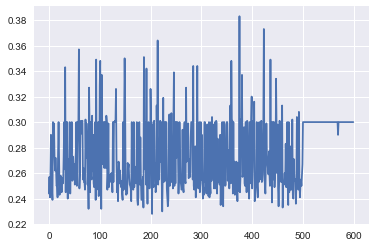

In [270]:
plt.plot(range(len(trials.losses())), trials.losses())

In [271]:
trials.best_trial

{'book_time': None,
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'classifier__C': [203],
   'classifier__coef0': [203],
   'classifier__degree': [203],
   'classifier__gamma': [203],
   'classifier__tol': [203],
   'imputation__strategy': [203]},
  'tid': 203,
  'vals': {'classifier__C': [9.655901125001087],
   'classifier__coef0': [-0.5452179627147997],
   'classifier__degree': [5],
   'classifier__gamma': [0.008100323606403094],
   'classifier__tol': [0.0016022879455736218],
   'imputation__strategy': ['median']},
  'workdir': None},
 'owner': None,
 'refresh_time': None,
 'result': {'loss': 0.22799999999999998, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 203,
 'version': 0}

## Conclusion
This certainly shows some promising results. I have to investiage a bit more because it seems the search is stuck in some local point because the objective value of most of the proposed hyperparamters are constant.
Moreover, the behaviour is a bit random, sometimes s